<a href="https://colab.research.google.com/github/Paraml3sS/PySpark/blob/main/MMDS_Challenge_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

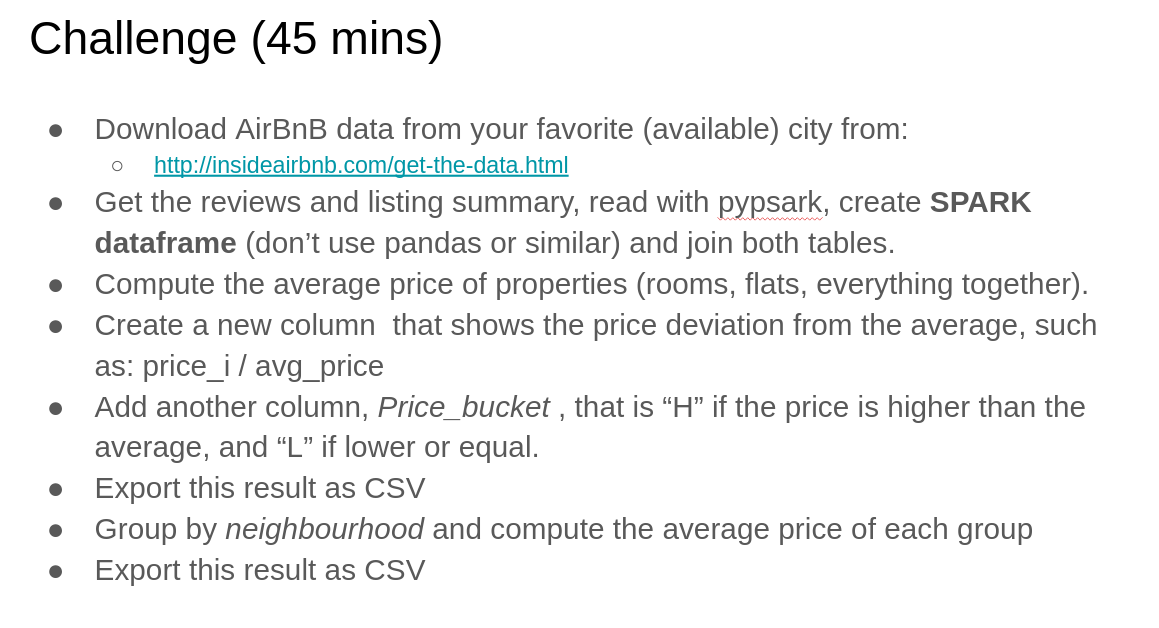

In [ ]:
pip install pyspark

In [2]:
from pyspark import SparkFiles
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
spark.sparkContext.addFile("https://raw.githubusercontent.com/Paraml3sS/PySpark/main/data/listings.csv?token=AJIWF7G3WAZRABNVZCTKCTLBKBBUO")
spark.sparkContext.addFile("https://raw.githubusercontent.com/Paraml3sS/PySpark/main/data/reviews.csv?token=AJIWF7F2CKH734MQJ6CHWHDBKBB2W")

In [52]:
listings = spark.read.csv(SparkFiles.get("listings.csv"), header=True, multiLine=True, inferSchema=True, escape='"', enforceSchema=True)
reviews = spark.read.csv(SparkFiles.get("reviews.csv"), header=True, multiLine=True, inferSchema=True, escape='"', enforceSchema=True)

In [53]:
listings.show(3)
reviews.show(3)

+------+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|    id|                name|host_id|host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+------+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
| 50904|aplace/antwerp: c...| 234077|    Karin|               null|Historisch Centrum|51.21825|  4.39901|     Hotel room|  153|             1|                1| 2015-05-06|             0.01|                             4|             258|
| 67776|Beautiful Big Hou...| 334804|      A

In [54]:
listings.createOrReplaceTempView("listings")
reviews.createOrReplaceTempView("reviews")

In [55]:
listingsReviews = spark.sql(
    """
    select * from listings
    inner join reviews on listings.id = reviews.listing_id
    """
)

In [56]:
listingsReviews.createOrReplaceTempView("listingsReviews")
listingsReviews.show(3)

+-----+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------+----------+
|   id|                name|host_id|host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|listing_id|      date|
+-----+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------+----------+
|50904|aplace/antwerp: c...| 234077|    Karin|               null|Historisch Centrum|51.21825|  4.39901|     Hotel room|  153|             1|                1| 2015-05-06|             0.01|                             4|

### Average prices among reviewed listings

In [57]:
average_prices_by_room_type = spark.sql(
    """
    select room_type, avg(price)
    from listingsReviews
    group by room_type
    """
)

average_price_overall = spark.sql(
    """
    select 'Overall' as room_type, avg(price)
    from listingsReviews
    """
)

average_prices = average_prices_by_room_type.union(average_price_overall)

average_prices.show()

+---------------+------------------+
|      room_type|        avg(price)|
+---------------+------------------+
|    Shared room| 63.31818181818182|
|     Hotel room| 88.61538461538461|
|Entire home/apt| 92.73233418786565|
|   Private room|51.580638095933416|
|        Overall| 83.13370641556222|
+---------------+------------------+



### Deviation

In [58]:
average_price = average_price_overall.collect()[0][1]
average_price

83.13370641556222

In [61]:
listingsReviews = spark.sql(
    f"""
    select *, price / {average_price} as `deviation`
    from listingsReviews
    """
)

listingsReviews.show(3)

+-----+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------+----------+----------------+----------------+
|   id|                name|host_id|host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|listing_id|      date|       deviation|       deviation|
+-----+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------+----------+----------------+----------------+
|50904|aplace/antwerp: c...| 234077|    Karin|               null|Historisch Centrum|51.21825|  4.39901|     Hotel roo

### Higher or lower than average column

In [62]:
listingsReviews = spark.sql(
    f"""
    select *, 
    case when price > {average_price} then 'H'
         else 'L'
    end as price_bucket
    from listingsReviews
    """
)

listingsReviews.show(3)

+-----+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------+----------+----------------+------------+
|   id|                name|host_id|host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|listing_id|      date|       deviation|price_bucket|
+-----+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------+----------+----------------+------------+
|50904|aplace/antwerp: c...| 234077|    Karin|               null|Historisch Centrum|51.21825|  4.39901|     Hotel room|  153|    

In [63]:
listingsReviews.createOrReplaceTempView("listingsReviews")

In [65]:
listingsReviews.show(3)

+-----+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------+----------+----------------+------------+
|   id|                name|host_id|host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|listing_id|      date|       deviation|price_bucket|
+-----+--------------------+-------+---------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------+----------+----------------+------------+
|50904|aplace/antwerp: c...| 234077|    Karin|               null|Historisch Centrum|51.21825|  4.39901|     Hotel room|  153|    

In [66]:
listingsReviews.repartition(1).write.csv("listing_reviews.csv")

### Average price by neighbourhood

In [68]:
avg_price_by_neighbourhood = spark.sql(
    """
    select neighbourhood, avg(price)
    from listingsReviews
    group by neighbourhood
    """
)

avg_price_by_neighbourhood.show(3)

+--------------------+-----------------+
|       neighbourhood|       avg(price)|
+--------------------+-----------------+
|       Oud - Berchem|77.85702614379085|
|Borgerhout Extra ...|58.99469964664311|
|          Haringrode|74.93810444874275|
+--------------------+-----------------+
only showing top 3 rows



In [69]:
avg_price_by_neighbourhood.repartition(1).write.csv("avg_price_by_neighbourhood.csv")